# Vehicle Loan Prediction Machine Learning Model

# Chapter 8 - Class Balancing

### Recap and Load
- As always, let's begin by importing our libraries and loading the data
- Notice that we are importing SMOTE from imblearn.over_sampling and resample from sklearn.utils

*Throughout this chapter you may see slightly different results to those on the demo videos. The outputs vary due to the random nature of the random forest algorithm and some of the sampling we will use but they should be similar to those in the videos*

*Some of the models we will build here are a bit more complex, if you are running into memory related issues try and free up memory by closing down any programs that you do not need to complete the chapter*

##### If you do not have the imblearn package installed then you should install it by running "pip install imblearn" from the command line

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, roc_curve, auc, precision_score, plot_confusion_matrix
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE


In [4]:
loan_df = pd.read_csv('../data/vehicle_loans_feat.csv', index_col='UNIQUEID')

In [7]:
category_cols = ['MANUFACTURER_ID', 'STATE_ID', 'DISBURSAL_MONTH', 'DISBURSED_CAT', 'PERFORM_CNS_SCORE_DESCRIPTION', 'EMPLOYMENT_TYPE']
loan_df[category_cols] = loan_df[category_cols].astype('category')

In [8]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [9]:
def eval_model(model, x_test, y_test):
    preds = model.predict(x_test)
    probs = model.predict_proba(x_test)

    conf_mat = confusion_matrix(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    plot_confusion_matrix(model, x_test, y_test)
    plt.show()

    #print(conf_mat)
    print("\n")
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)

    #Show ROC Curve 
    fpr, tpr, threshold = roc_curve(y_test, probs[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    print("AUC: ", roc_auc)

    plot_roc_curve(fpr, tpr, roc_auc)

    results_df = pd.DataFrame()
    results_df['true_class'] = y_test
    results_df['predicted_class'] = list(preds)
    results_df['default_prob'] = probs[:, 1]

    #plot the distribution of probabilities for the estimated classes 
    sns.distplot(results_df[results_df['true_class'] == 0]['default_prob'], label="No Default", hist=False)
    sns.distplot(results_df[results_df['true_class'] == 1]['default_prob'], label="Default", hist=False)
    plt.title('Distribution of Probabilities for Estimated Classes')
    plt.legend(loc='best')
    plt.show()
    
    #see the true class versus predicted class as a percentage
    print(results_df.groupby('true_class')['predicted_class'].value_counts(normalize=True))

In [10]:
def encode_and_split(loan_df):
    loan_data_dumm = pd.get_dummies(loan_df, prefix_sep='_', drop_first=True)

    x = loan_data_dumm.drop(['LOAN_DEFAULT'], axis=1)
    y = loan_data_dumm['LOAN_DEFAULT']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    return x_train, x_test, y_train, y_test

## Lesson 1 - Weight Balancing 

### Random Forest 

- Just for fun let's build and train the random forest classifier with the parameters we found in chapter 7

### EXERCISE 

- Create training and test data for the full feature set 
- Use the tuned hyperparameters from the previous chapter to create a baseline Random Forest


### SOLUTION

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


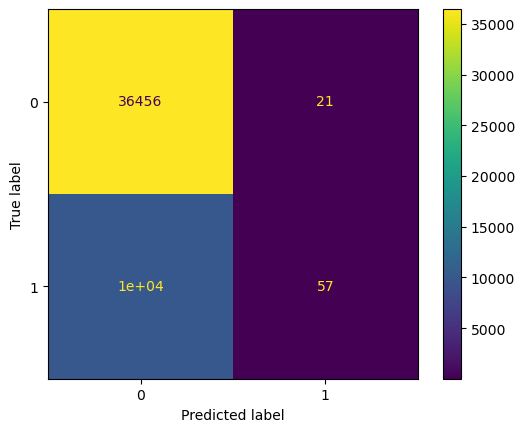



Accuracy:  0.7830198794793163
Precision:  0.7307692307692307
Recall:  0.005613551309828639
F1:  0.011141516810007817
AUC:  0.6485998467583102


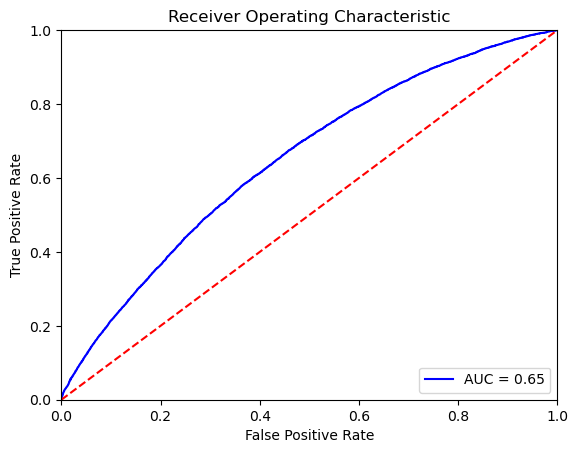

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


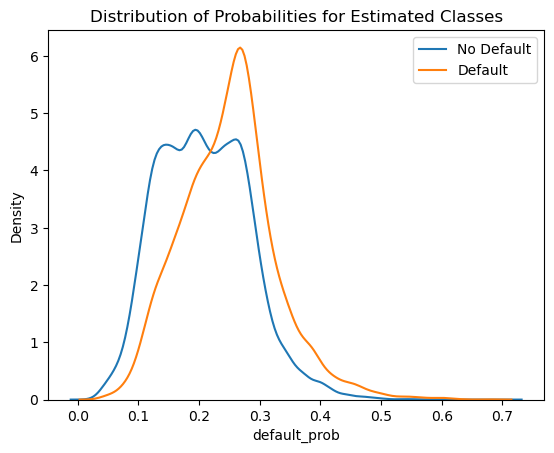

true_class  predicted_class
0           0                  0.999424
            1                  0.000576
1           0                  0.994386
            1                  0.005614
Name: predicted_class, dtype: float64


In [11]:
#type solution here
x_train, x_test, y_train, y_test = encode_and_split(loan_df)
rfc_model = RandomForestClassifier(n_estimators = 100, max_depth = 15)

rfc_model.fit(x_train, y_train)
eval_model(rfc_model, x_test, y_test)


- This model is the best we have seen so far at separating the two classes, but it is still not managing to identify many defaults
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) has a class_weight parameter that can be used to address the problem of class imbalance 
- By setting class_weight to 'balanced', we tell sklearn to automatically adjust the weights for each class so that they have equal influence during model training


C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


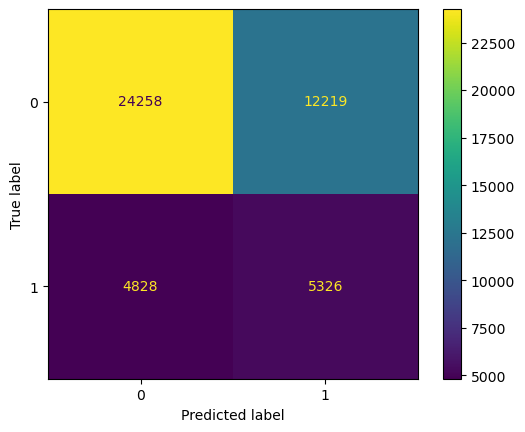



Accuracy:  0.6344277412022046
Precision:  0.3035622684525506
Recall:  0.524522355721883
F1:  0.3845626195891549
AUC:  0.6385593299436181


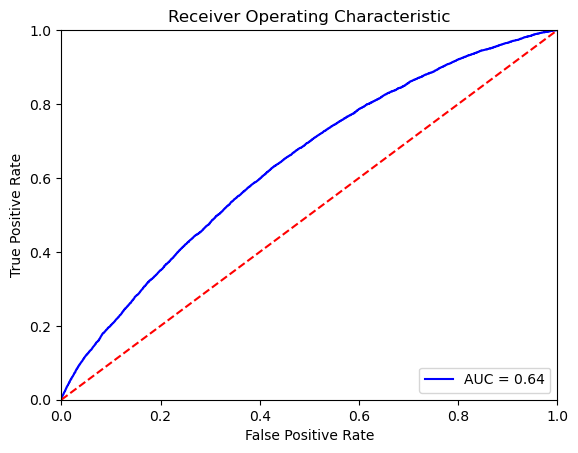

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


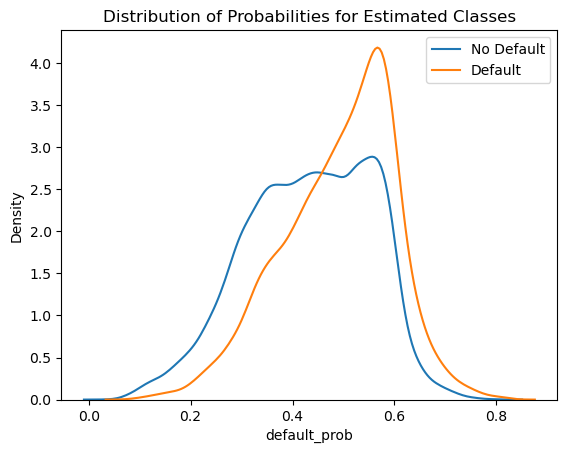

true_class  predicted_class
0           0                  0.665022
            1                  0.334978
1           1                  0.524522
            0                  0.475478
Name: predicted_class, dtype: float64


In [12]:
#balance rfc
rfc_model = RandomForestClassifier(n_estimators = 100, max_depth = 15, class_weight='balanced')

rfc_model.fit(x_train, y_train)
eval_model(rfc_model, x_test, y_test)

Some big changes to the model performance

### Accuracy 

- Dropped to ~63%

### Precision 

- 30% down from 66% for the random forest with default class weighting
- Less of the instances we classified as defaults actually were defaults 

### Recall 

- Recall has increased dramatically, from 0.5% to 53%!
- We are now able to correctly identify over half of the loan defaults
- However, we are also incorrectly classifying a large number of non-defaults as defaults

### F1

- The F1 score has also increased dramatically from 0.01 to 38 
- We have a much more balanced model than we did previously

### AUC 

- The area under the roc curve has dropped from 0.65 to 0.64

### Probability Distributions 

- The main peak for non-defaults is inline with the peak for defaults, this makes sense as we know the model is classifying a lot of non-defaults as defaults

Generally, this is a better, more balanced model than the previous ones. However the large numbers of non-defaults predicted as defaults is concerning

### Manual Class Weighting

Passing 'balanced' to the class weight parameter adjusts the class weights so that both classes carry equal influence 

We can also pass a dictionary to class weights to manually set class weightings 

- default (no class weighting) is equivalent to class_weight = {0:0.5, 1:0.5}
- In our case 'balanced' is equivalent to class_weight = {0:0.217, 1:0.783}
- With balanced classes we are incorrectly predicting too many defaults
- Let's tweak the class weights to see if we can amend this

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


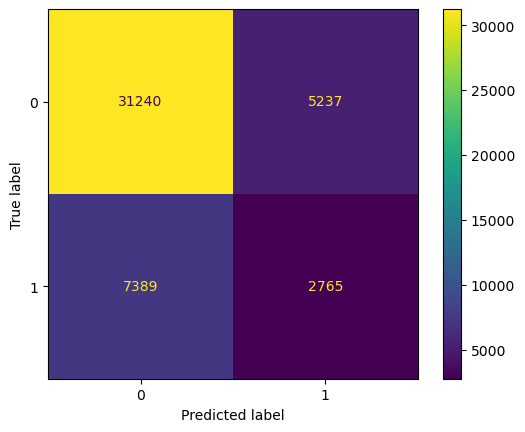



Accuracy:  0.7292359160215307
Precision:  0.3455386153461635
Recall:  0.2723064802048454
F1:  0.3045825071601675
AUC:  0.6419814058606703


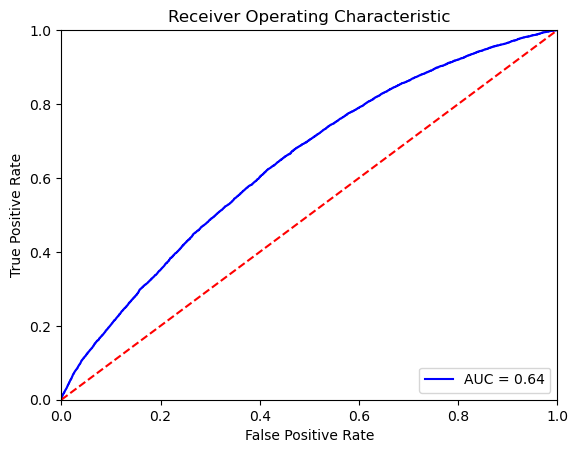

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


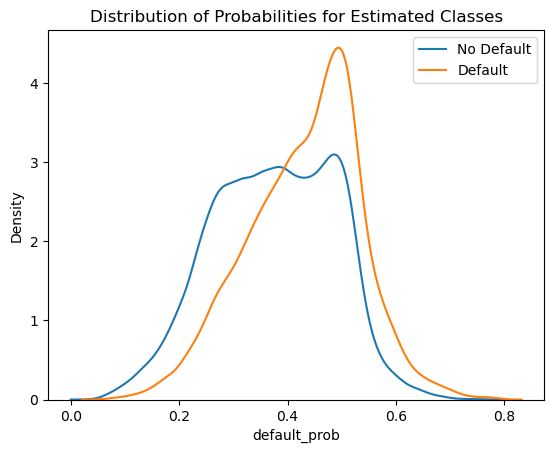

true_class  predicted_class
0           0                  0.856430
            1                  0.143570
1           0                  0.727694
            1                  0.272306
Name: predicted_class, dtype: float64


In [13]:
#manually weighted rfc
weights = {0:0.27, 1:0.73}

rfc_model = RandomForestClassifier(n_estimators = 100, max_depth = 15, class_weight=weights)

rfc_model.fit(x_train, y_train)
eval_model(rfc_model, x_test, y_test)

We have increased the precision and accuracy, but the recall has dropped dramatically!

Hopefully, you are starting to see that the process of building and tweaking models is iterative and often there is no definitive best answer, just alternatives

## Lesson 2 - Resampling

- We will look at Upsampling, Downsampling and SMOTE (Synthetic Minority Oversampling)
- IMPORTANT - Resampling should only be done on the training data, test data should always reflect the 'natural class distribution'

### Upsampling

- Upsampling is the process of resampling the minority class to match the number of instances in the majority
- We only want to resample the training data so let's join the x_train and y_train into one DataFrame
- We create a [copy](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.copy.html) of x_train to avoid the need to recreate our train test split later

In [14]:
#copy x_train
train_df = x_train.copy()
train_df['LOAN_DEFAULT'] = y_train

- Let's make sure we know what the class distribution looks like 

In [15]:
#check target variable
print(train_df['LOAN_DEFAULT'].value_counts())
print(train_df['LOAN_DEFAULT'].value_counts(normalize=True))

0    146066
1     40457
Name: LOAN_DEFAULT, dtype: int64
0    0.783099
1    0.216901
Name: LOAN_DEFAULT, dtype: float64


- Class distribution is what we expected
- Now we can create subsets for each class value

In [16]:
#split by target classes
train_minority = train_df[train_df['LOAN_DEFAULT'] == 1]
train_majority = train_df[train_df['LOAN_DEFAULT'] == 0]

sklearn provides us with the [resample](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html) function

we pass it 4 parameters 
- the dataframe which we want to resample
- replace: boolean indicating that we want to resample with replacement
- n_samples: the number of samples to be created 
- random_state: random seed for repeatability

In [19]:
#perform upsampling
train_minority_up = resample(train_minority, replace=True,  n_samples=train_majority.shape[0], random_state=123)

We should now have two DataFrames, train_majority and train_minority_up. These should both have the same number of rows
- all the instances in train_majority should be of class 0
- all the instances in train_minority_up should be of class 1

In [20]:
#check class distribution
print(train_majority['LOAN_DEFAULT'].value_counts())
print(train_minority_up['LOAN_DEFAULT'].value_counts())

0    146066
Name: LOAN_DEFAULT, dtype: int64
1    146066
Name: LOAN_DEFAULT, dtype: int64


Nice! now we can use the [concat](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) function from pandas to join the two dataframes together

In [21]:
#create full training set
train_up_df = pd.concat([train_majority, train_minority_up])

Let's check the class distribution, it should be 50/50

In [22]:
#check target variable distribution
print(train_up_df['LOAN_DEFAULT'].value_counts())
print(train_up_df['LOAN_DEFAULT'].value_counts(normalize=True))

0    146066
1    146066
Name: LOAN_DEFAULT, dtype: int64
0    0.5
1    0.5
Name: LOAN_DEFAULT, dtype: float64


Finally, we need to separate the target variable from our features and then re-train/evaluate the model

In [23]:
#split features fron labels
x_train_up = train_up_df.drop(['LOAN_DEFAULT'], axis=1)
y_train_up = train_up_df['LOAN_DEFAULT']

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


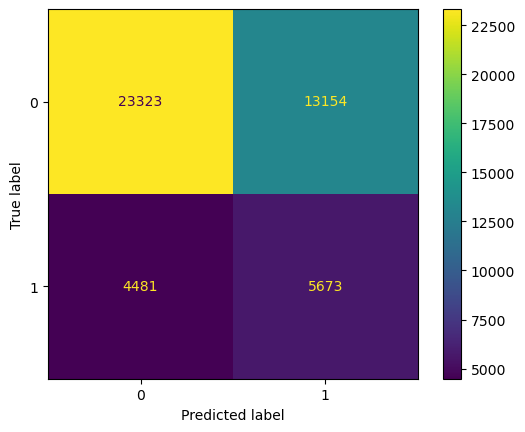



Accuracy:  0.6218181038365036
Precision:  0.3013225686514049
Recall:  0.5586960803624188
F1:  0.3914978779200165
AUC:  0.6429108703783377


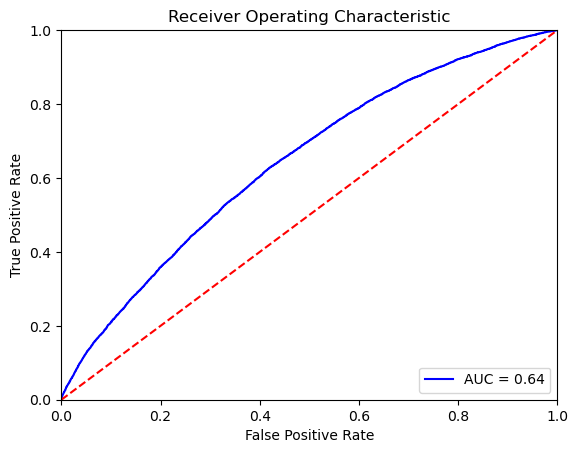

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


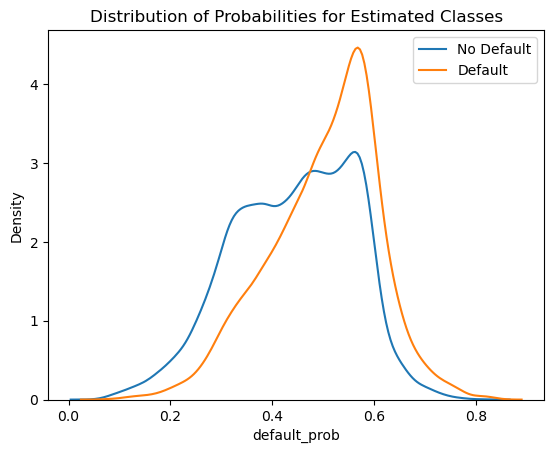

true_class  predicted_class
0           0                  0.639389
            1                  0.360611
1           1                  0.558696
            0                  0.441304
Name: predicted_class, dtype: float64


In [24]:
#train and eval
rfc_model = RandomForestClassifier(n_estimators = 100, max_depth=15)

rfc_model.fit(x_train_up, y_train_up)
eval_model(rfc_model, x_test, y_test)

Almost identical results to using 'balanced' class weights. This makes sense if you think about it! 

### Downsampling

- Produce balanced training data by downsampling the majority class to match the minority
- We have provided a function balance subsample to help you easily perform up or downsampling!

In [25]:
def balance_sample(x_train, y_train, sample_mode='up'):
    train_df = x_train.copy()
    train_df['LOAN_DEFAULT'] = y_train

    train_minority = train_df[train_df['LOAN_DEFAULT'] == 1]
    train_majority = train_df[train_df['LOAN_DEFAULT'] == 0]

    train_sampled_df = pd.DataFrame()

    if sample_mode == 'down':
        train_majority_down = resample(train_majority, replace=False,  n_samples=train_minority.shape[0], random_state=123)
        train_sampled_df = pd.concat([train_minority, train_majority_down])  
    else:
        train_minority_up = resample(train_minority, replace=True,  n_samples=train_majority.shape[0], random_state=123)
        train_sampled_df = pd.concat([train_majority, train_minority_up])

    x_train_samp = train_sampled_df.drop(['LOAN_DEFAULT'], axis=1)
    y_train_samp = train_sampled_df['LOAN_DEFAULT']

    return x_train_samp, y_train_samp 

How about downsampling on the Random Forest

### EXERCISE

- Use the balance_sample function to create downsampled training data
- HINT: look at the 'sample_mode' parameter

### SOLUTION

In [26]:
#type solution here
x_train_dwn, y_train_dwn = balance_sample(x_train, y_train, sample_mode='down')

print(y_train_dwn.value_counts())
print(y_train_dwn.value_counts(normalize=True))

1    40457
0    40457
Name: LOAN_DEFAULT, dtype: int64
1    0.5
0    0.5
Name: LOAN_DEFAULT, dtype: float64


Nice, lets train and evaluate a RandomForestClassifier using the downsampled training data

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


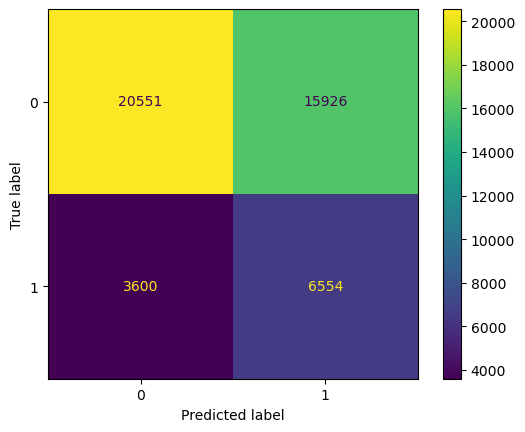



Accuracy:  0.5812656816281014
Precision:  0.2915480427046263
Recall:  0.6454599172739807
F1:  0.4016669730955445
AUC:  0.6466849614546073


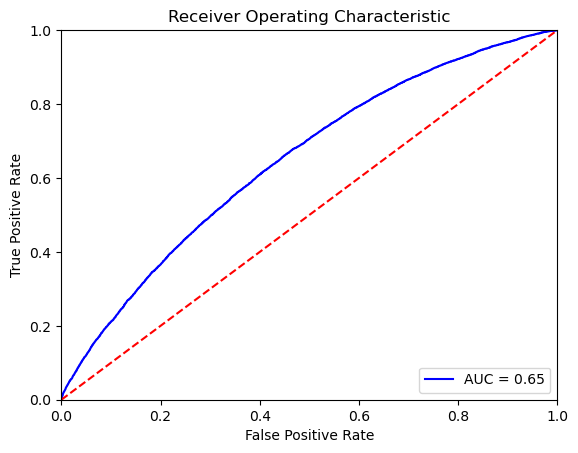

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


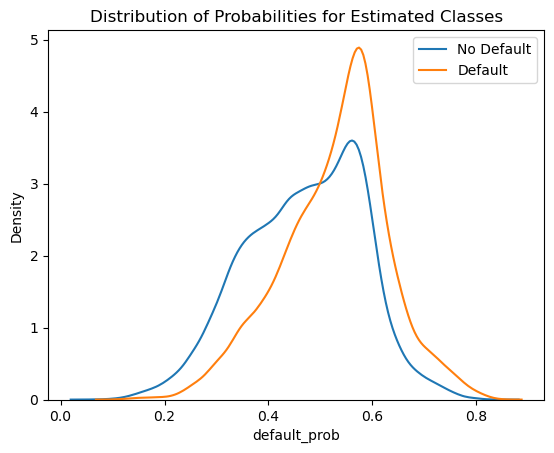

true_class  predicted_class
0           0                  0.563396
            1                  0.436604
1           1                  0.645460
            0                  0.354540
Name: predicted_class, dtype: float64


In [27]:
#train model
rfc_model = RandomForestClassifier(n_estimators = 100, max_depth = 15)

rfc_model.fit(x_train_dwn, y_train_dwn)
eval_model(rfc_model, x_test, y_test)

### SMOTE

- [SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html) upsamples the minority class 
- Rather than simply duplicating data, SMOTE creates new synthetic instances

Let's use SMOTE to create a synthetically upsampled training set

First initialize smote

In [34]:
#initialize SMOTE
smote = SMOTE()

Now we create the training data using fit_resample

In [35]:
#create sampled training data
x_train_synth, y_train_synth = smote.fit_resample(x_train, y_train)

*NB - If SMOTE takes too long to run or causes a memory error on your machine please uncomment and run the code in the cell below to use the pre-sampled training data we have provided*

In [ ]:
# vehicle_train_synth = pd.read_csv('../data/vehicle_train_synth.csv')

# x_train_synth = vehicle_train_synth.drop(['LOAN_DEFAULT'], axis=1)
# y_train_synth = vehicle_train_synth['LOAN_DEFAULT']

Double check the class distribution

In [36]:
#check class distribution
print(y_train_synth.value_counts())
print(y_train_synth.value_counts(normalize=True))

1    146066
0    146066
Name: LOAN_DEFAULT, dtype: int64
1    0.5
0    0.5
Name: LOAN_DEFAULT, dtype: float64


Now train and evaluate the model with the SMOTE sampled training data

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


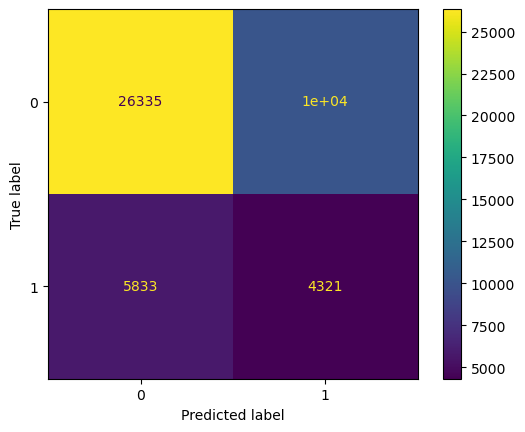



Accuracy:  0.6574167399369518
Precision:  0.2987623591232801
Recall:  0.4255465826275359
F1:  0.3510582118048503
AUC:  0.6230438072770812


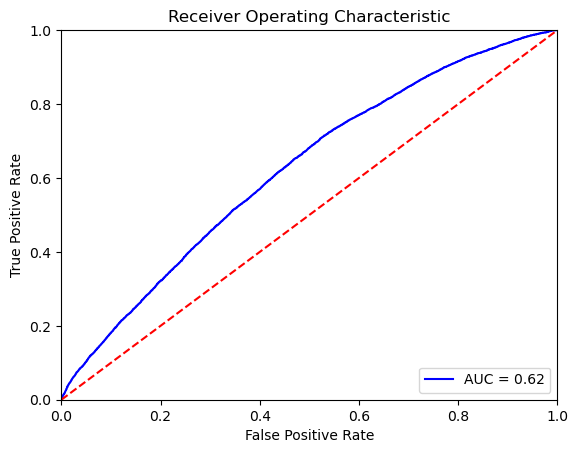

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


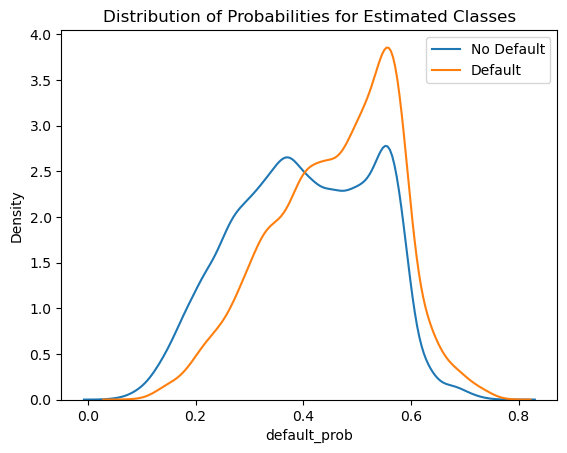

true_class  predicted_class
0           0                  0.721962
            1                  0.278038
1           0                  0.574453
            1                  0.425547
Name: predicted_class, dtype: float64


In [37]:
#train model
rfc_model = RandomForestClassifier(n_estimators = 100, max_depth = 15)

rfc_model.fit(x_train_synth, y_train_synth)
eval_model(rfc_model, x_test, y_test)

- Using SMOTE we have trained a model which labels a lot of our test data with the default class
- We again have quite poor precision around 30%
- The AUC is down to ~0.62
- And 57% of our defaulted loans were incorrectly labelled as non-defaults!

## Conclusion

- Well done for making it to the end of the course! 
- Throughout this course, we have demonstrated how to preprocess data, build models and optimize those models 
- Loan default prediction is difficult, in the real world large teams of experienced data scientists work on these problems every day
- The main thing you should takeaway from this course is practical skills that will allow you to perform preprocessing and predictive modelling on your own datasets 